<a href="https://colab.research.google.com/github/Deleon57/EDAR-REGRESSION/blob/main/RandomForrest1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


In [2]:
data1 = pd.read_csv("GFI_dataset.csv")

# Convert Date column to datetime
data1['Date'] = pd.to_datetime(data1['Date'])
data1 = data1.sort_values('Date')
data1.set_index('Date', inplace=True)

print(data1.head())


                  Close         High          Low         Open
Date                                                          
2012-12-31  9091.963867  9151.554951  8999.072886  9104.232763
2013-01-01  9091.963867  9091.963867  9091.963867  9091.963867
2013-01-02  9323.318359  9325.946504  9043.767691  9151.556707
2013-01-03  9335.583984  9376.772209  9183.978625  9289.138496
2013-01-04  9049.024414  9131.399905  8955.256723  9113.873744


/tmp/ipython-input-218794384.py:5: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data1['Date'] = pd.to_datetime(data1['Date'])


In [3]:
from statsmodels.tsa.stattools import adfuller

# Loop through each feature
for col in ["Close", "High", "Low", "Open"]:
    result = adfuller(data1[col].dropna())
    print(f"Feature: {col}")
    print("  ADF Statistic:", result[0])
    print("  p-value:", result[1])
    print("-" * 40)


Feature: Close
  ADF Statistic: -0.8927524476821448
  p-value: 0.790349769845352
----------------------------------------
Feature: High
  ADF Statistic: -1.129604601213029
  p-value: 0.7031227284341343
----------------------------------------
Feature: Low
  ADF Statistic: -1.0113363349123317
  p-value: 0.7491072102344439
----------------------------------------
Feature: Open
  ADF Statistic: -1.0917706683810122
  p-value: 0.7183424850696943
----------------------------------------


In [4]:
# Define the ADF test function
def adf_test(series, title=''):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'Augmented Dickey-Fuller Test: {title}')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('-'*50)

features = data1.select_dtypes(include=[np.number]).columns

# Calculate percentage change (returns)
data_returns = data1[features].pct_change().dropna()

# Run ADF test on each feature
for col in features:
    adf_test(data_returns[col], title=f"{col} (Returns)")

Augmented Dickey-Fuller Test: Close (Returns)
ADF Statistic: -40.17952119272028
p-value: 0.0
--------------------------------------------------
Augmented Dickey-Fuller Test: High (Returns)
ADF Statistic: -39.88932325419743
p-value: 0.0
--------------------------------------------------
Augmented Dickey-Fuller Test: Low (Returns)
ADF Statistic: -13.49927808718864
p-value: 2.9990343346863835e-25
--------------------------------------------------
Augmented Dickey-Fuller Test: Open (Returns)
ADF Statistic: -18.951097277075363
p-value: 0.0
--------------------------------------------------


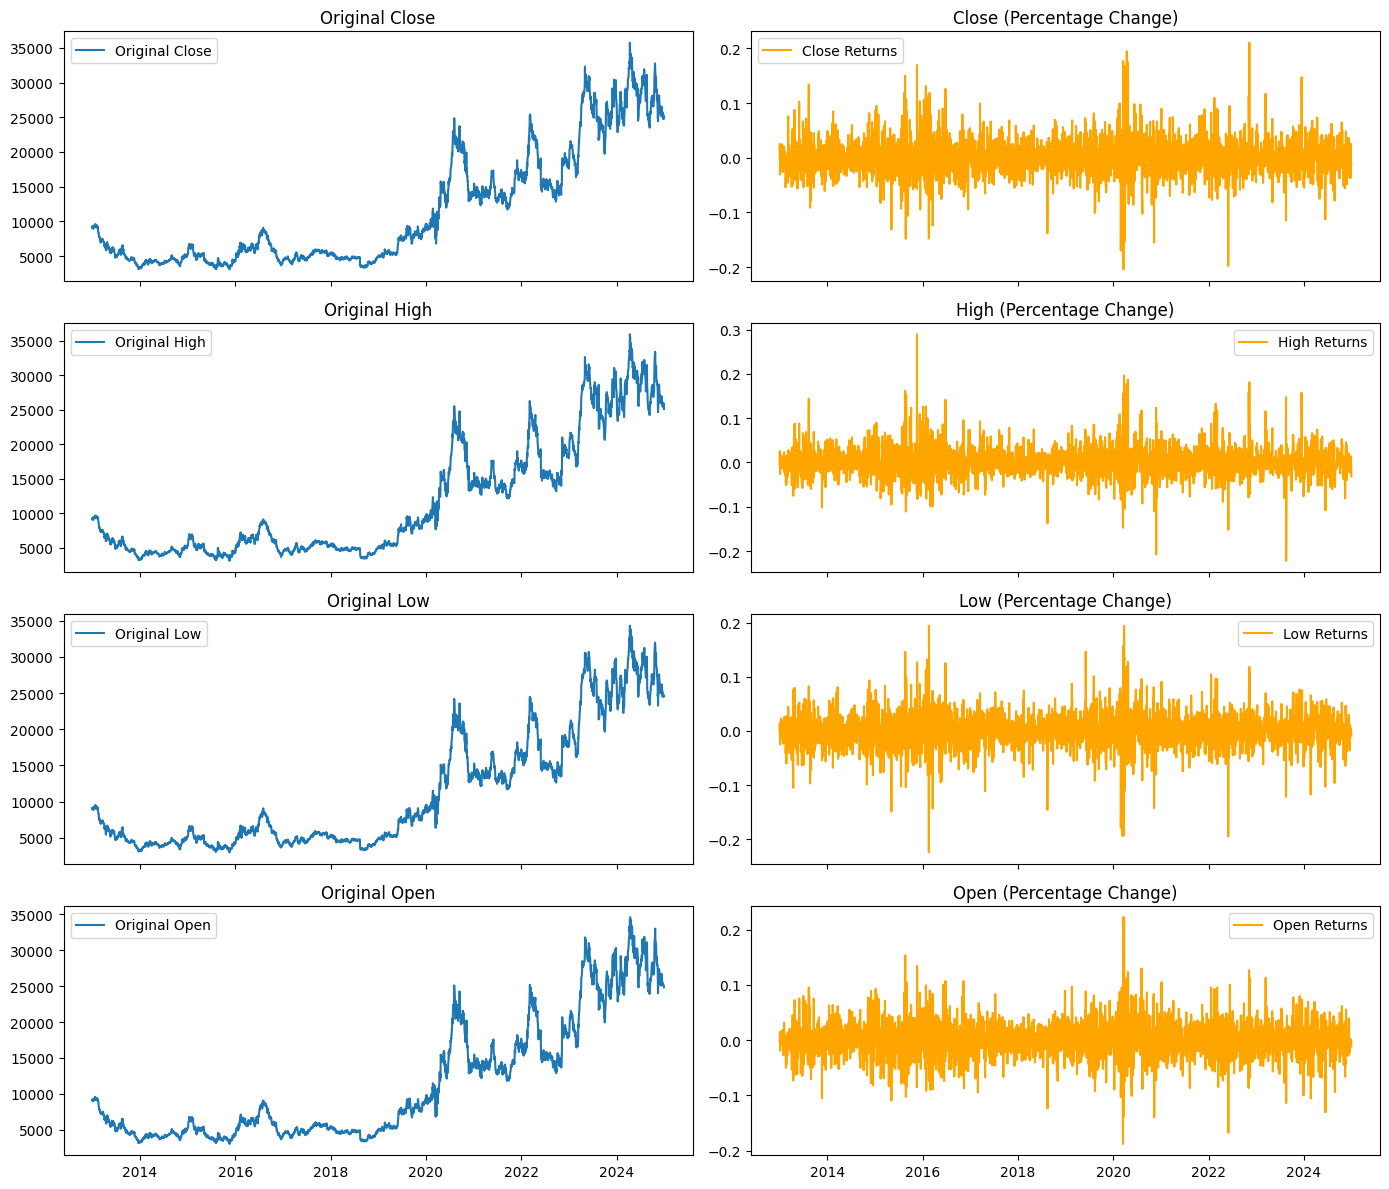

In [5]:
n_features = len(features)
fig, axes = plt.subplots(n_features, 2, figsize=(14, 3*n_features), sharex=True)

for i, col in enumerate(features):

    axes[i,0].plot(data1[col], label=f"Original {col}")
    axes[i,0].set_title(f"Original {col}")
    axes[i,0].legend()

    axes[i,1].plot(data_returns[col], label=f"{col} Returns", color='orange')
    axes[i,1].set_title(f"{col} (Percentage Change)")
    axes[i,1].legend()

plt.tight_layout()
plt.show()

In [6]:

data_returns.to_csv("GFI_dataset_returns.csv", index=True)

print("✅ Stationary dataset saved as 'GFI_dataset_returns.csv'")

✅ Stationary dataset saved as 'GFI_dataset_returns.csv'


In [7]:
from sklearn.preprocessing import StandardScaler

train = data_returns[data_returns.index < "2023-01-01"]
test  = data_returns[data_returns.index >= "2023-01-01"]

# Features (X) and Target (y)
X_train = train[["High", "Low", "Open"]]
y_train = train["Close"]

X_test = test[["High", "Low", "Open"]]
y_test = test["Close"]

print("Before scaling:")
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nAfter scaling:")
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

Before scaling:
Train shape: (2551, 3) (2551,)
Test shape: (497, 3) (497,)

After scaling:
X_train_scaled shape: (2551, 3)
X_test_scaled shape: (497, 3)


In [8]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)  # To tune n_estimators later
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n🌲 Random Forest Model Evaluation")
print("MSE:", mse)
print("R²:", r2)



🌲 Random Forest Model Evaluation
MSE: 0.0003173422092023134
R²: 0.5967604698500417


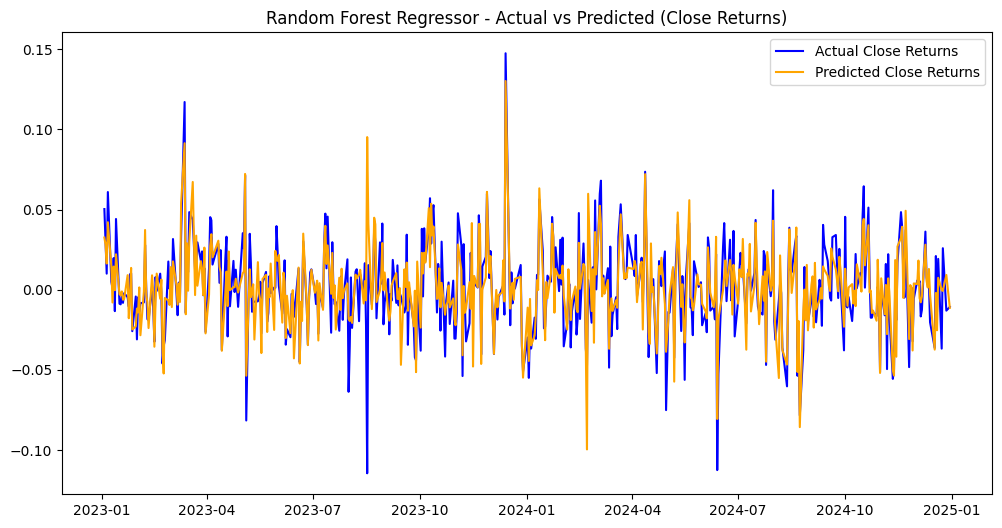

In [9]:

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label="Actual Close Returns", color="blue")
plt.plot(y_test.index, y_pred, label="Predicted Close Returns", color="orange")
plt.title("Random Forest Regressor - Actual vs Predicted (Close Returns)")
plt.legend()
plt.show()


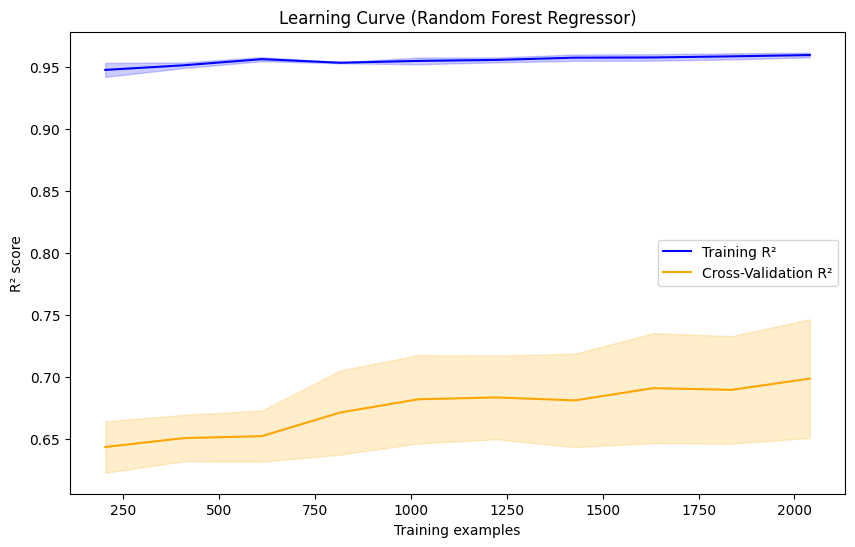

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=rf_model,
    X=X_train,
    y=y_train,
    cv=5,                     # 5-fold cross validation
    scoring="r2",             # use R² score
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores, axis=1)

plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label="Training R²", color="blue")
plt.plot(train_sizes, test_mean, label="Cross-Validation R²", color="orange")

plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2, color="blue")
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.2, color="orange")

plt.title("Learning Curve (Random Forest Regressor)")
plt.xlabel("Training examples")
plt.ylabel("R² score")
plt.legend(loc="best")
plt.show()


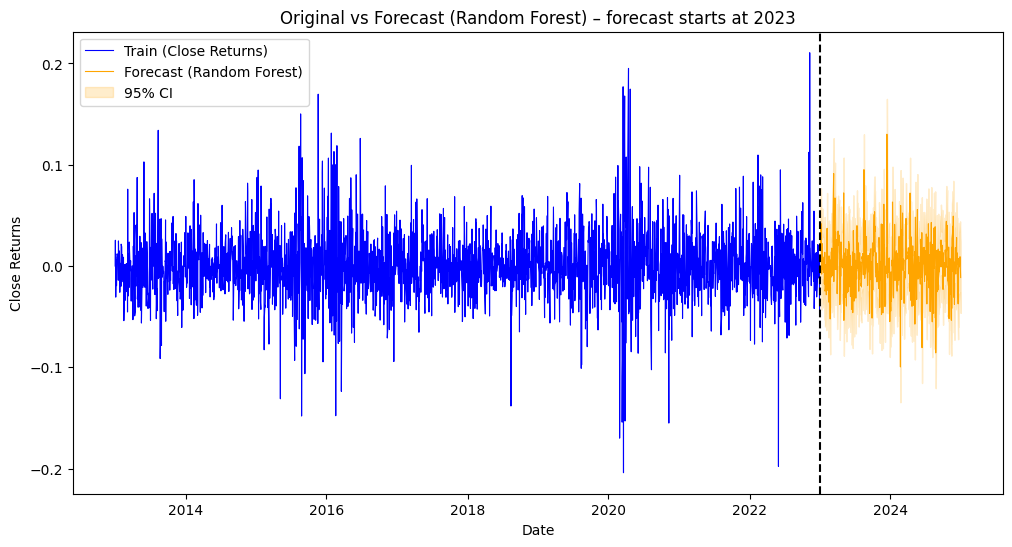

In [ ]:
error = y_test.values - y_pred
err_std = np.std(error)
lower = y_pred - 1.96 * err_std
upper = y_pred + 1.96 * err_std

plt.figure(figsize=(12,6))

# Training data (blue) – use actual index
plt.plot(y_train.index, y_train.values, label="Train (Close Returns)", color="blue", linewidth=0.8)

# Forecast (orange) – align with test index
plt.plot(y_test.index, y_pred, label="Forecast (Random Forest)", color="orange", linewidth=0.8)

plt.fill_between(y_test.index, lower, upper, color="orange", alpha=0.2, label="95% CI")

plt.axvline(x=y_test.index[0], color="k", linestyle="--")

plt.title("Original vs Forecast (Random Forest) – forecast starts at 2023")
plt.xlabel("Date")
plt.ylabel("Close Returns")
plt.legend()
plt.show()


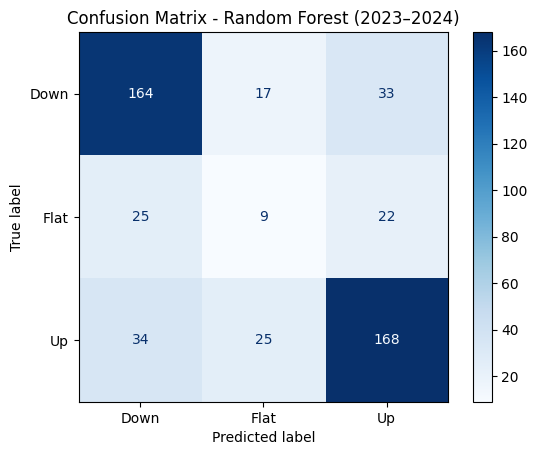

Classification Report - Random Forest
              precision    recall  f1-score   support

        Down       0.74      0.77      0.75       214
        Flat       0.18      0.16      0.17        56
          Up       0.75      0.74      0.75       227

    accuracy                           0.69       497
   macro avg       0.56      0.56      0.56       497
weighted avg       0.68      0.69      0.68       497



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

y_test_arr = np.array(y_test).flatten()
y_pred_arr = np.array(y_pred).flatten()

def to_class(delta, eps=None):
    """
    Convert price changes into classes:
    +1 = Up, -1 = Down, 0 = Flat (within epsilon threshold)
    """
    if eps is None:
        eps = 0.1 * np.std(delta)

    cls = np.zeros_like(delta, dtype=int)
    cls[delta > eps] = 1          # Up
    cls[delta < -eps] = -1        # Down
    return cls

delta_true = np.diff(y_test_arr, prepend=y_test_arr[0])
delta_pred = np.diff(y_pred_arr, prepend=y_pred_arr[0])

true_cls = to_class(delta_true)
pred_cls = to_class(delta_pred)

labels = [-1, 0, 1]  # Down, Flat, Up
cm = confusion_matrix(true_cls, pred_cls, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down", "Flat", "Up"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Random Forest (2023–2024)")
plt.show()

print("Classification Report - Random Forest")
print(classification_report(true_cls, pred_cls, target_names=["Down", "Flat", "Up"]))


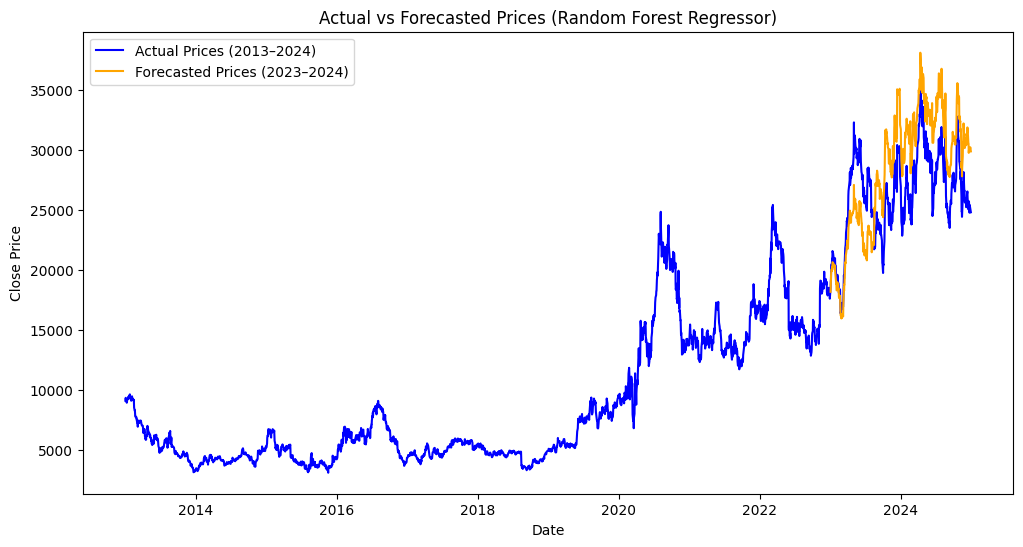

In [ ]:
P0 = data1["Close"].iloc[0]

# Rebuild prices from returns
reconstructed_prices = (1 + data_returns["Close"]).cumprod() * P0

last_price_2022 = data1.loc[data1.index < "2023-01-01", "Close"].iloc[-1]

# Convert forecasted returns (y_pred) into price levels
forecast_prices = (1 + pd.Series(y_pred, index=y_test.index)).cumprod() * last_price_2022

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

plt.plot(reconstructed_prices.index, reconstructed_prices, label="Actual Prices (2013–2024)", color="blue")

plt.plot(forecast_prices.index, forecast_prices, label="Forecasted Prices (2023–2024)", color="orange")

plt.title("Actual vs Forecasted Prices (Random Forest Regressor)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()


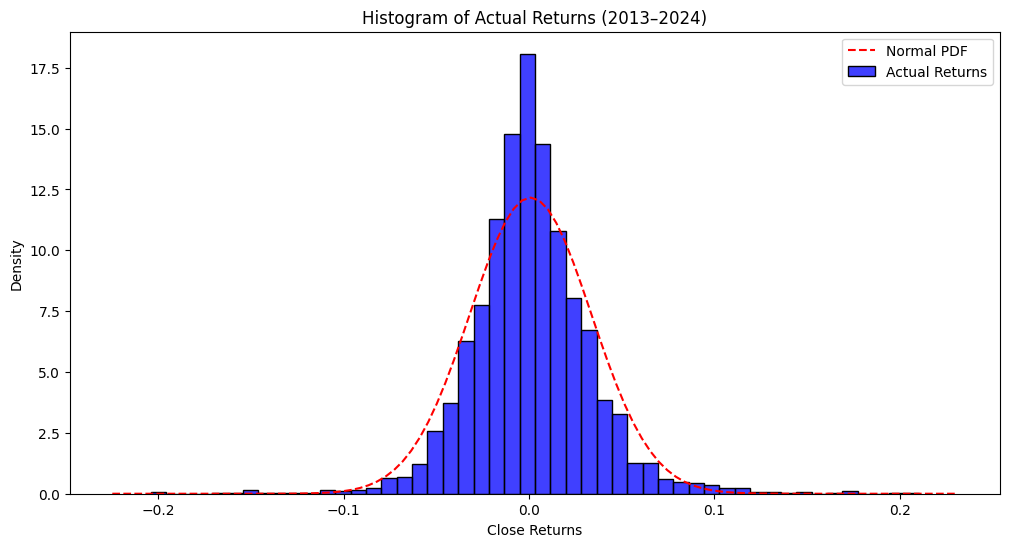

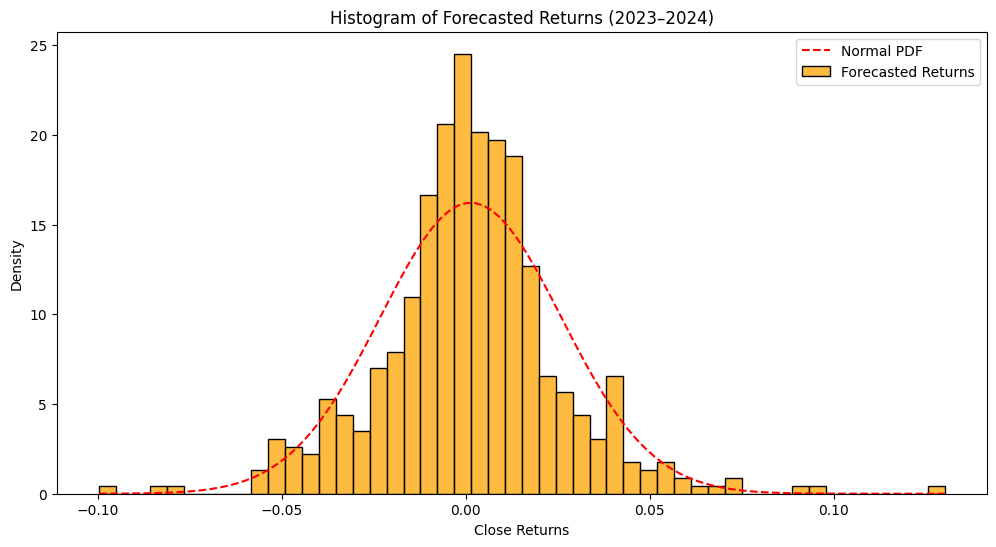

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

plt.figure(figsize=(12,6))
sns.histplot(data_returns["Close"], bins=50, kde=False, color="blue", stat="density", label="Actual Returns")

mu, std = stats.norm.fit(data_returns["Close"].dropna())
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, "r--", label="Normal PDF")

plt.title("Histogram of Actual Returns (2013–2024)")
plt.xlabel("Close Returns")
plt.ylabel("Density")
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
sns.histplot(y_pred, bins=50, kde=False, color="orange", stat="density", label="Forecasted Returns")

mu, std = stats.norm.fit(y_pred)
x = np.linspace(min(y_pred), max(y_pred), 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, "r--", label="Normal PDF")

plt.title("Histogram of Forecasted Returns (2023–2024)")
plt.xlabel("Close Returns")
plt.ylabel("Density")
plt.legend()
plt.show()


# These two histograms compare the distribution of actual stock returns (2013–2024) with the distribution of forecasted returns (2023–2024) from your Random Forest model. The blue chart shows the real historical returns, and the orange chart shows the model’s predicted returns. Both are overlaid with a red dashed curve representing a normal (bell-shaped) distribution. What this means is that in reality, returns are clustered around zero with a few extreme spikes (fat tails), while the model’s forecasted returns are also centered around zero but appear slightly smoother and narrower. In simple terms: the model has captured the general shape of the return distribution (most returns being small and close to zero), but it may underestimate the likelihood of extreme large moves compared to the actual historical data.